Sample script for MNLab2BICN.

メディアネットワーク実験IIB 項目Iで利用するサンプル．

PSK および QAM は適切に実装されていません．`要修正`を要修正です．

必要なファイルを`github`から取り出す．

In [ ]:
!test -d mnlab2bicn && (cd mnlab2bicn ; git pull) || git clone https://github.com/htsutsui/mnlab2bicn/
!cp mnlab2bicn/mnlab2bicn.py .
!cp mnlab2bicn/gray.py .

Cloning into 'mnlab2bicn'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 115 (delta 62), reused 76 (delta 36), pack-reused 0
Receiving objects: 100% (115/115), 28.66 KiB | 5.73 MiB/s, done.
Resolving deltas: 100% (62/62), done.


`mnlab2bicn`が依存する`gmpy2` (BER計算を高速化する)をインストールする．
なお，`gmpy2`が無くてもBER計算は可能(若干遅くなる)なので，エラーが生じる場合は無視すること．

In [ ]:
!sudo apt-get update
!sudo apt-get install -y libgmp-dev libmpfr-dev libmpc-dev
!pip install gmpy2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

NumPy と Matplotlib を使うので`import`する．

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

実験で使用するあらかじめ用意されている関数を`import`する．

In [ ]:
from mnlab2bicn import awgn, calc_ser, calc_ber, \
    int2gray, gray2int, scatter_plot

このscript中で利用するdebug用の変数．

In [ ]:
verbose = True # True だと for loop の処理の状況(進み具合)が確認できる
verbose_awgn = False

PSKのシミュレーションを行う関数を定義する．

In [ ]:
def psk_test(m_level, i_snr, i_size, plot=False, gray=False):
    """PSK test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)

    x = int2gray(src) if gray else src

    # Start of 要修正
    y = np.exp(1j*np.pi*2/m_level*x)
    for i in range(x.shape[0]):
        if x[i] % 2 == 0:
            y[i] = 0.5 * np.exp(1j*np.pi*2/m_level*x[i])
        else:
            y[i] = np.exp(1j*np.pi*2/m_level*x[i]) 
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"PSK_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    z = np.angle(y_noisy)
    z = z/(np.pi*2/m_level)
    z = z.round()
    z = np.array(z.round(), dtype='int')
    z = np.where(z<0, z+m_level, z)
    # End of 要修正

    z = np.array(z, dtype='int')

    dst = gray2int(z) if gray else z

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

QAMのシミュレーションを行う関数を定義する．

In [ ]:
def qam_test(m_level, i_snr, i_size, plot=False, gray=False):
    """QAM test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)
    k = int(np.log2(m_level))
    smax = 2 ** (k // 2) - 1

    yr = src >> (k // 2)
    yi = src & smax

    yr = int2gray(yr) if gray else yr
    yi = int2gray(yi) if gray else yi

    # Start of 要修正
    yr = (2 * yr) / smax - 1
    yi = (2 * yi) / smax - 1
    y = yr + (1j * yi)
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"QAM_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    zr = (y_noisy.real + 1) / 2 * smax
    zi = (y_noisy.imag + 1) / 2 * smax
    zr = zr.round()
    zi = zi.round()
    zr = np.array(zr, dtype='int')
    zi = np.array(zi, dtype='int') 
    # End of 要修正

    zr = np.where(zr < 0, 0, zr)
    zr = np.where(zr > smax, smax, zr)
    zi = np.where(zi < 0, 0, zi)
    zi = np.where(zi > smax, smax, zi)

    zr = gray2int(zr) if gray else zr
    zi = gray2int(zi) if gray else zi

    dst = zr << (k // 2)
    dst += zi

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

グラフのフォントサイズを調整する．

In [ ]:
plt.rcParams.update({'font.size': 16})

PSKのシミュレーションを行う．図は`PSK_4_30_100.png`および`PSK_4_30_100.pdf`に保存される．以下同様．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

(0.0, 0.0)

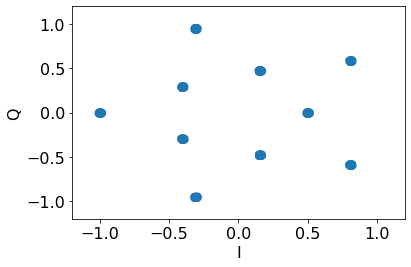

In [ ]:
psk_test(10, 40, 20000, plot=True)

(0.275, 0.127175)

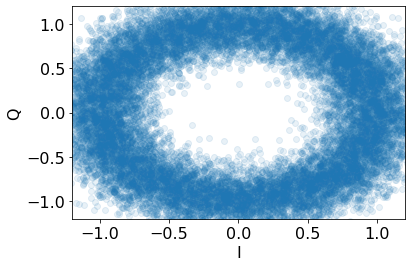

In [ ]:
psk_test(16, 12, 20000, plot=True)

(0.78425, 0.274325)

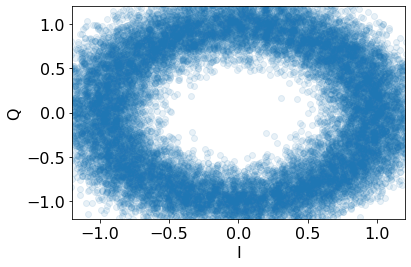

In [ ]:
psk_test(64, 12, 20000, plot=True)

QAMのシミュレーションを行う．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

(0.0001, 5e-05)

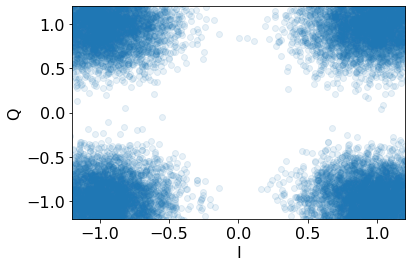

In [ ]:
qam_test(4, 12, 20000, plot=True, gray=True)

(0.1092, 0.0375875)

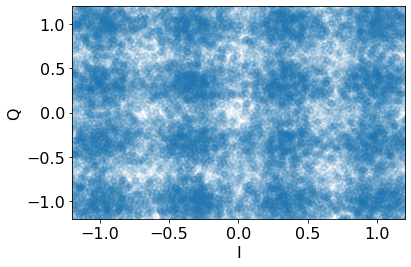

In [ ]:
qam_test(16, 12, 20000, plot=True)

(0.56195, 0.17613333333333334)

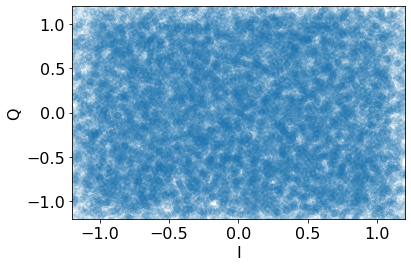

In [ ]:
qam_test(64, 12, 20000, plot=True)

グラフのフォントサイズを調整する．

In [ ]:
plt.rcParams.update({'font.size': 12})

PSK/QAM Comparison

課題3．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.943725, 0.4231141666666667]
[2, 64, 0.929335, 0.4020975]
[4, 64, 0.911285, 0.37853]
[6, 64, 0.89088, 0.3550025]
[8, 64, 0.86223, 0.3292625]
[10, 64, 0.82606, 0.30224666666666666]
[12, 64, 0.7819, 0.27448833333333333]
[14, 64, 0.72832, 0.2489125]
[16, 64, 0.660935, 0.22040916666666666]
[18, 64, 0.581935, 0.19105583333333334]
[20, 64, 0.486965, 0.159045]
[22, 64, 0.38206, 0.12538833333333332]
[24, 64, 0.27212, 0.08934]
[26, 64, 0.16659, 0.05465166666666667]
[28, 64, 0.080895, 0.0266575]
[30, 64, 0.028365, 0.009371666666666667]
[32, 64, 0.00576, 0.001885]
[34, 64, 0.00051, 0.0001525]
[36, 64, 1e-05, 1.6666666666666667e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.92328, 0.3637625]
[2, 64, 0.900935, 0.34448833333333334]
[4, 64, 0.869095, 0.3201716666666667]
[6, 64, 0.822555, 0.29243916666666664]
[8, 64, 0.76055, 0.26039833333333334]
[10, 64, 0.67316, 0.2217925]
[12, 64, 0.55818, 0.17529]
[14, 64, 0.42111, 0.12540416666666668]
[16, 64, 0.271325, 0.0767625]
[18, 64, 0.139485, 0.0379725]
[20, 6

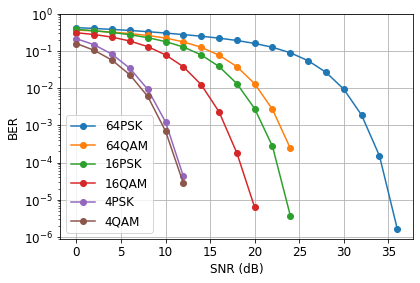

In [ ]:
size = 200000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_QAM.png")
plt.savefig("PSK_QAM.pdf")

PSK Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.943548, 0.422242]
[2, 64, 0.929784, 0.401962]
[4, 64, 0.91249, 0.3789613333333333]
[6, 64, 0.890276, 0.354119]
[8, 64, 0.862036, 0.328692]
[10, 64, 0.82661, 0.3024133333333333]
[12, 64, 0.781602, 0.27562]
[14, 64, 0.728538, 0.24871666666666667]
[16, 64, 0.662726, 0.220685]
[18, 64, 0.582408, 0.19147266666666668]
[20, 64, 0.487112, 0.15974533333333332]
[22, 64, 0.382388, 0.12537566666666666]
[24, 64, 0.270426, 0.088623]
[26, 64, 0.166002, 0.054428]
[28, 64, 0.081598, 0.026820333333333335]
[30, 64, 0.02859, 0.009395666666666667]
[32, 64, 0.005776, 0.00187]
[34, 64, 0.000526, 0.000169]
[36, 64, 1.6e-05, 4.666666666666666e-06]
[38, 64, 0.0, 0.0]
[0, 64, 0.942734, 0.3812026666666667]
[2, 64, 0.930102, 0.3575973333333333]
[4, 64, 0.912354, 0.33122566666666664]
[6, 64, 0.889994, 0.303974]
[8, 64, 0.861928, 0.276147]
[10, 64, 0.825952, 0.248216]
[12, 64, 0.781282, 0.221182]
[14, 64, 0.727626, 0.194224]
[16, 64, 0.662002, 0.166718]
[18, 64, 0.582008, 0.13852733333333334]
[20, 64, 0.48

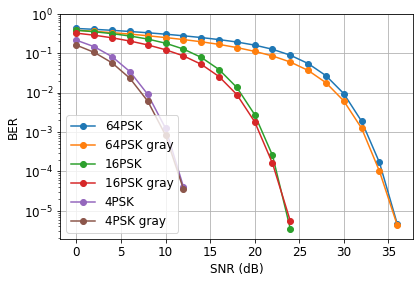

In [ ]:
size = 500000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_gray.png")
plt.savefig("PSK_gray.pdf")

QAM Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.92324, 0.36314166666666664]
[2, 64, 0.900705, 0.343465]
[4, 64, 0.8677, 0.3198416666666667]
[6, 64, 0.823175, 0.292135]
[8, 64, 0.759755, 0.26049916666666667]
[10, 64, 0.67305, 0.22193666666666667]
[12, 64, 0.559135, 0.17517833333333332]
[14, 64, 0.422585, 0.125695]
[16, 64, 0.27289, 0.07718666666666667]
[18, 64, 0.14057, 0.03828666666666666]
[20, 64, 0.0515, 0.0137325]
[22, 64, 0.01035, 0.002704166666666667]
[24, 64, 0.00099, 0.0002716666666666667]
[26, 64, 2.5e-05, 5.833333333333333e-06]
[28, 64, 0.0, 0.0]
[0, 64, 0.92353, 0.35931416666666666]
[2, 64, 0.901265, 0.3218841666666667]
[4, 64, 0.86945, 0.2836808333333333]
[6, 64, 0.823485, 0.245705]
[8, 64, 0.759215, 0.20668333333333333]
[10, 64, 0.67323, 0.168055]
[12, 64, 0.562325, 0.13008]
[14, 64, 0.420105, 0.09113916666666666]
[16, 64, 0.27301, 0.05607]
[18, 64, 0.14068, 0.027786666666666668]
[20, 64, 0.05024, 0.00965]
[22, 64, 0.010635, 0.0020158333333333335]
[24, 64, 0.00081, 0.00015916666666666667]
[26, 64, 5e-06, 1.6666

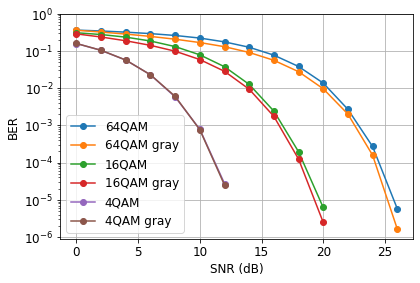

In [ ]:
size = 200000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("QAM_gray.png")
plt.savefig("QAM_gray.pdf")